<h1 style="font-size:32px; color:Black;">Cybersecurity Project: Suspicious Web Threat Interactions</h1>


<h1 style="font-size:32px; color:Black;">1: Data import and basic overview</h1>


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest


#Load dataset
df = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')

#view basic information
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


<h1 style="font-size:32px; color:Black;">2: Data Preprocessing</h1>

Handle missing values, outliers, and data inconsistencies

In [6]:
#Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64


In [26]:
#Fill or drop missing values as needed
df['bytes_in'].fillna(df['bytes_in'].median(), inplace=True)
df.dropna(subset=['src_ip', 'dst_ip'], inplace = True)

#Convert columns to appropriate datatypes
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

C:\Users\jianl\AppData\Local\Temp\ipykernel_7776\1025413937.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bytes_in'].fillna(df['bytes_in'].median(), inplace=True)


<h1 style="font-size:32px; color:Black;">Step 3: Exploratory Data Analysis(EDA)</h1>


Analyze Traffic Patterns Based on bytes_in and bytes_out

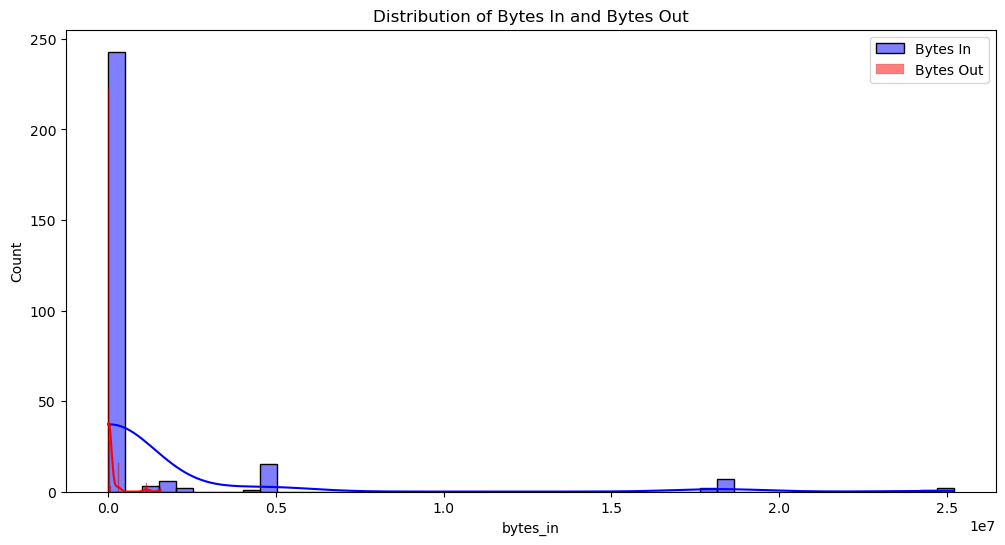

In [9]:
#Distribution of bytes in and bytes out
plt.figure(figsize=(12, 6))
sns.histplot(df['bytes_in'], bins=50, color='blue', kde=True, label='Bytes In')
sns.histplot(df['bytes_out'], bins=50, color='red', kde=True, label='Bytes Out')
plt.legend()
plt.title('Distribution of Bytes In and Bytes Out')
plt.show()

Count of Protocols Used

C:\Users\jianl\AppData\Local\Temp\ipykernel_7776\4259760943.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='protocol', data=df, palette='viridis')


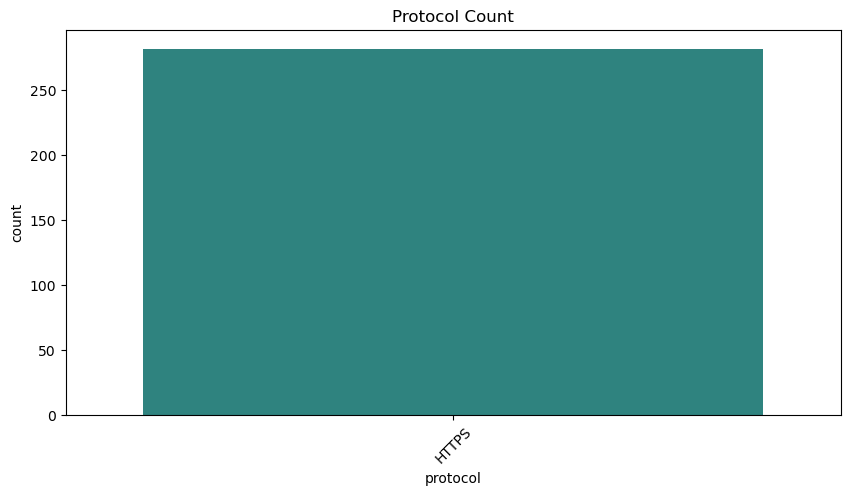

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(x='protocol', data=df, palette='viridis')
plt.title('Protocol Count')
plt.xticks(rotation=45)
plt.show()

#Document for report
#“All observed traffic in the dataset uses HTTPS, indicating secure client-server communication. No unencrypted or unusual protocols were detected.”

<h1 style="font-size:32px; color:Black;">Step 4: Feature Engineering</h1>


Extract useful features, like duration and average packet size, to aid in analysis

In [12]:
#Duration of the session in seconds
df['session_duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()

#Average packet size
df['avg_packet_size'] = (df['bytes_in'] + df['bytes_out'])/df['session_duration']

print(df[['session_duration', 'avg_packet_size']].head())

   session_duration  avg_packet_size
0             600.0        30.986667
1             600.0        81.830000
2             600.0        69.956667
3             600.0        74.706667
4             600.0        34.030000


<h1 style="font-size:32px; color:Black;">Step 5: Data Visualization</h1>


Country-based Interaction Analysis

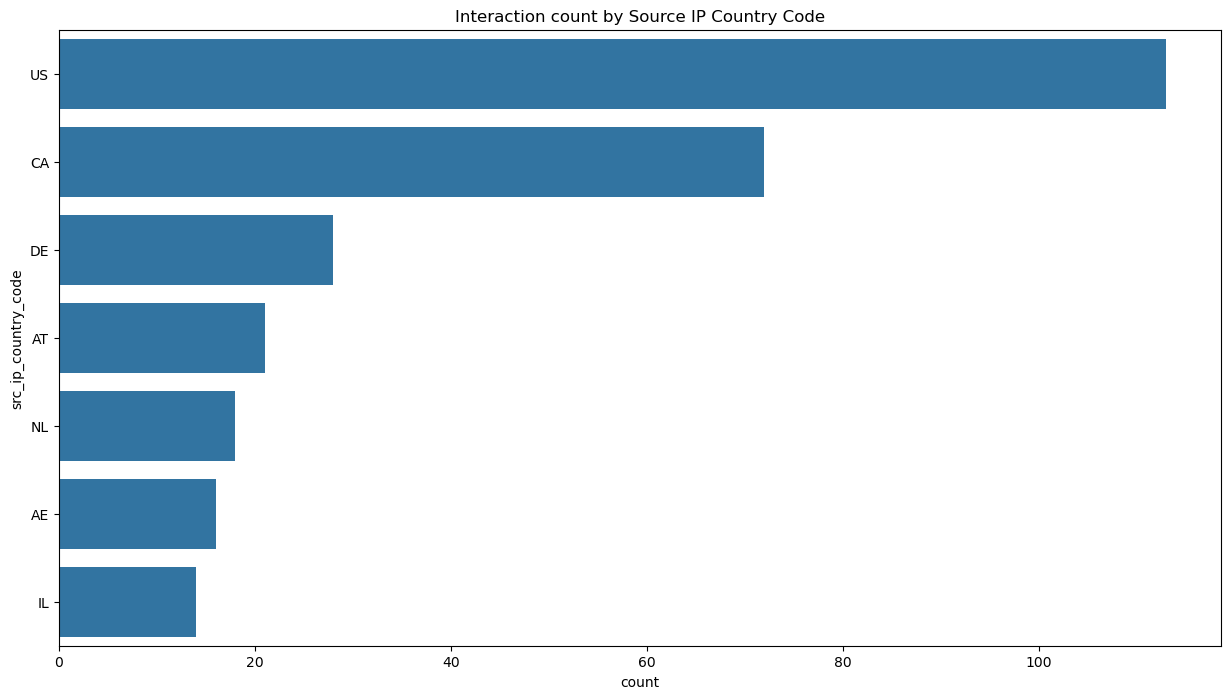

In [13]:
plt.figure(figsize=(15, 8))
sns.countplot(y='src_ip_country_code', data=df, order=df['src_ip_country_code'].value_counts().index)
plt.title('Interaction count by Source IP Country Code')
plt.show()

Suspicious Activities Based on Ports

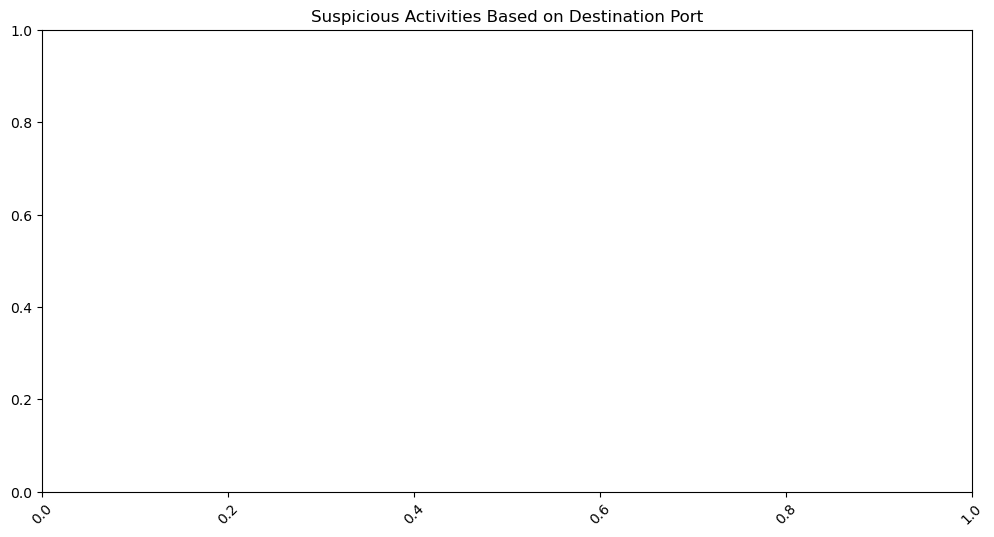

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(x='dst_port', data=df[df['detection_types']=='Suspicious'], palette='coolwarm')
plt.title('Suspicious Activities Based on Destination Port')
plt.xticks(rotation=45)
plt.show()

In [15]:
df[df['detection_types'].str.lower() == 'suspicious']


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,session_duration,avg_packet_size


<h1 style="font-size:32px; color:Black;">Step 6: Modeling Anomaly Detection</h1>


This step uses Isolation Forest, a common technique for detecting anomalies

In [18]:
#Selecting features for anomaly detection
features = df[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]

#Initialize the model
model = IsolationForest(contamination=0.05, random_state=42)

#Fit and predict anomalies
df['anomaly'] = model.fit_predict(features)
df['anomaly'] = df['anomaly'].apply(lambda x: 'Suspicious' if x == -1 else 'Normal')

display(df[df['anomaly'] == 'Suspicious'].head())


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,session_duration,avg_packet_size,anomaly
36,4190330,283456,2024-04-25 23:30:00+00:00,2024-04-25 23:40:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:30:00Z,waf_rule,600.0,7456.310000,Suspicious
87,1215594,64362,2024-04-26 00:30:00+00:00,2024-04-26 00:40:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T00:30:00Z,waf_rule,600.0,2133.260000,Suspicious
116,4827283,306181,2024-04-26 01:00:00+00:00,2024-04-26 01:10:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T01:00:00Z,waf_rule,600.0,8555.773333,Suspicious
132,1889834,34306,2024-04-26 01:20:00+00:00,2024-04-26 01:30:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T01:20:00Z,waf_rule,600.0,3206.900000,Suspicious
153,4869181,301752,2024-04-26 01:40:00+00:00,2024-04-26 01:50:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T01:40:00Z,waf_rule,600.0,8618.221667,Suspicious


In [25]:
#Export suspicious records:
df[df['anomaly'] == 'Suspicious'].to_csv('suspicious_sessions.csv', index=False)

<h1 style="font-size:32px; color:Black;">Step 7:Evaluation</h1>


Evaluate the anomaly detection model by clicking its accuracy in identifying suspicious activities

In [20]:
#Check the proportion of anomalies detected
print(df['anomaly'].value_counts())

#Display anomaly samples
suspicious_activities = df[df['anomaly'] == 'Suspicious']

display(suspicious_activities.head())

anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,session_duration,avg_packet_size,anomaly
36,4190330,283456,2024-04-25 23:30:00+00:00,2024-04-25 23:40:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:30:00Z,waf_rule,600.0,7456.310000,Suspicious
87,1215594,64362,2024-04-26 00:30:00+00:00,2024-04-26 00:40:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T00:30:00Z,waf_rule,600.0,2133.260000,Suspicious
116,4827283,306181,2024-04-26 01:00:00+00:00,2024-04-26 01:10:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T01:00:00Z,waf_rule,600.0,8555.773333,Suspicious
132,1889834,34306,2024-04-26 01:20:00+00:00,2024-04-26 01:30:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T01:20:00Z,waf_rule,600.0,3206.900000,Suspicious
153,4869181,301752,2024-04-26 01:40:00+00:00,2024-04-26 01:50:00+00:00,155.91.45.242,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-26T01:40:00Z,waf_rule,600.0,8618.221667,Suspicious


<h1 style="font-size:32px; color:Black;">Step 8: Visualization of Anomalies</h1>


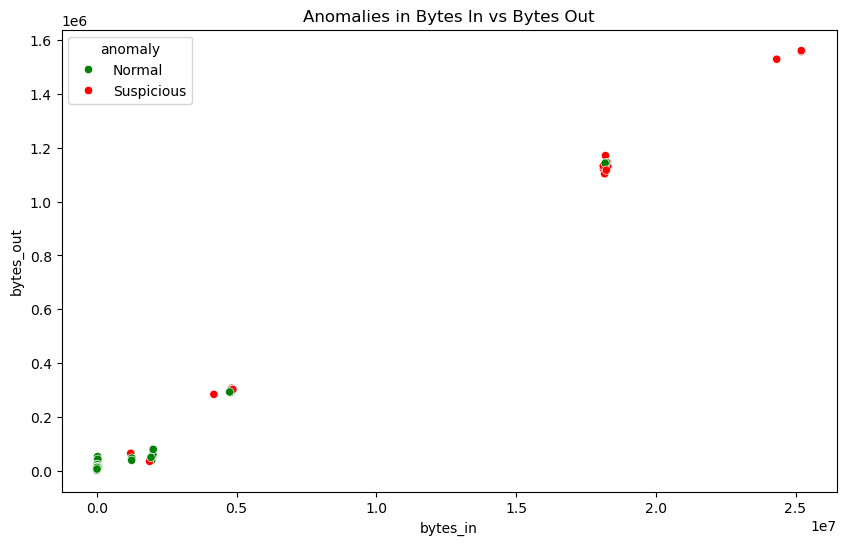

In [23]:
#visualize bytes_in vs bytes_out with anomalies highlighted
plt.figure(figsize=(10,6))
sns.scatterplot(x='bytes_in', y='bytes_out', hue = 'anomaly', data=df, palette = ['green', 'red'])
plt.title('Anomalies in Bytes In vs Bytes Out')
plt.show()


<h1 style="font-size:32px; color:Black;">The Isolation Forest model identified suspicious web sessions based on bytes transferred and session behavior. Visuals confirmed the effectiveness of the model, and the project demonstrates how anomaly detection can enhance cybersecurity without needing labeled data.</h1>
